# Time Analysis

### Explanation
In this notebook will be analysed the temporal différence between the moment a command is sent by the state machine and the moment it is received by the Tool object.

First, let's import the necessary libraries and load the data.

## Libraries

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


Now let's load the two log files and parse them to extract the necessary information.

## Data

In [2]:
with open("../../../StateMachine/log.txt", "r") as f:
    log_sm_raw = f.read()

with open("../../log.txt", "r") as f:
    log_tool_raw = f.read()

log_sm_raw_lines   = log_sm_raw.split("\n")
log_tool_raw_lines = log_tool_raw.split("\n")

print("StateMachine log lines:", len(log_sm_raw_lines))
print("Tool log lines        :", len(log_tool_raw_lines))

# print an example of each log
print("StateMachine log example ================")
print(log_sm_raw_lines[len(log_sm_raw_lines) - 2])

StateMachine log lines: 493
Tool log lines        : 1629
StateMachine log example ================
[INFO] - 2024-05-28 15:47:13,449 - Command sent to Tools/T0_ReadAudio/fast_com/: start


In [3]:
# [INFO] - 2024-05-21 12:07:56,908 - Transition    S0 - S0          -->    S1 - S1

class LogLine:
    def __init__(self, type:str, date_time:datetime, message:str):
        self.type = type
        self.date_time = date_time
        self.message = message
    
    @classmethod
    def from_line(cls, line):
        if not line:
            return None
        parts = line.split(" - ")
        if len(parts) < 3:
            return None
        type = parts[0][1:-1]
        date_time_str = parts[1]
        date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S,%f')
        message = " - ".join(parts[2:])
        return cls(type, date_time, message)
    
    def __str__(self):
        return f"[{self.type}] - {self.date_time} - {self.message}"
    
    def __repr__(self):
        return f"LogLine({self.type}, {self.date_time}, {self.message})"

In [4]:
# Parse log lines
log_sm_lines = [LogLine.from_line(line) for line in log_sm_raw_lines]
log_tool_lines = [LogLine.from_line(line) for line in log_tool_raw_lines]

print("StateMachine log example ================")
print(log_sm_lines[len(log_sm_lines) - 2])
print(log_sm_lines[len(log_sm_lines) - 2].__dict__)

StateMachine log example ================
[INFO] - 2024-05-28 15:47:13.449000 - Command sent to Tools/T0_ReadAudio/fast_com/: start
{'type': 'INFO', 'date_time': datetime.datetime(2024, 5, 28, 15, 47, 13, 449000), 'message': 'Command sent to Tools/T0_ReadAudio/fast_com/: start'}


In [5]:
log_sm_df = pd.DataFrame([line.__dict__ for line in log_sm_lines if line is not None])
log_tool_df = pd.DataFrame([line.__dict__ for line in log_tool_lines if line is not None])

log_tool_df.head()

,type,date_time,message
0,INFO,2024-05-28 15:35:23.733,Starting the T9_LEDS process...
1,INFO,2024-05-28 15:35:23.733,Starting the T11_Gesture process...
2,INFO,2024-05-28 15:35:24.368,T9_LEDS object initialized successfully.
3,INFO,2024-05-28 15:35:24.578,T11_Gesture object initialized successfully.
4,INFO,2024-05-28 15:35:25.257,Starting the T0_ReadAudio process...


In [14]:
# add column detail to log_tool_df with
# - "stop" if "Executing command: stop" in message
# - "start" if "Executing command: start" in message
# add column concerned_tool with the state concerned by the command

def parse_tool_message(message):
    possible_tools = {"T0_ReadAudio", "T1_PersonRecognition", "T2_TextGeneration", "T3_TTS", "T4_ActionSelection", "T5_PerformAction", "T6_RecordAudio", "T7_CaptureImages", "T8_STT", "T9_LEDS", "T10_RetrieveAndAugment", "T11_Gesture"}
    for tool in possible_tools:
        if tool in message:
            return tool
    return None

log_tool_df["detail"] = np.where(log_tool_df["message"].str.contains("Executing command: stop"), "stop", 
                                 np.where(log_tool_df["message"].str.contains("Executing command: start"), "start",
                                          np.where(log_tool_df["message"].str.contains("Finished."), "end",
                                          None)))
log_tool_df["concerned_tool"] = log_tool_df["message"].apply(lambda x: parse_tool_message(x))
log_tool_df["detail_msg"] = log_tool_df["concerned_tool"]

# add column detail to log_sm_df with
# - "transition" if "Transition" in message
# add column transition_from and transition_to with the from and to states

def parse_transition_message(message):
    if not 'Transition' in message:
        return None, None
    parts = message.split()
    return parts[3], parts[7]

# transition if Transition in message, Command if Command in message
log_sm_df["detail"] = np.where(log_sm_df["message"].str.contains("Transition"), "transition",
                                 np.where(log_sm_df["message"].str.contains("Command"), "command",None))
log_sm_df["transition_from"] = log_sm_df["message"].apply(lambda x: parse_transition_message(x)[0] if x is not None else None)
log_sm_df["transition_to"] = log_sm_df["message"].apply(lambda x: parse_transition_message(x)[1] if x is not None else None)
log_sm_df["concerned_tool"] = log_sm_df["message"].apply(lambda x: parse_tool_message(x))
# detail_msg column being transition TO if detail is transition, else the concerned tool
log_sm_df["detail_msg"] = np.where(log_sm_df["detail"] == "transition", log_sm_df["transition_to"], log_sm_df["concerned_tool"])

log_sm_df.head()

,type,date_time,message,detail,transition_from,transition_to,concerned_tool,detail_msg
0,INFO,2024-05-28 15:37:22.102,StateMachine initialized,None,None,None,None,None
1,INFO,2024-05-28 15:37:22.134,Command sent to Tools/T0_ReadAudio/fast_com/: ...,command,None,None,T0_ReadAudio,T0_ReadAudio
2,INFO,2024-05-28 15:37:22.134,Starting StateMachine with initial state S0 - ...,None,None,None,None,None
3,INFO,2024-05-28 15:37:22.134,Command sent to Tools/T9_LEDS/fast_com/: reset,command,None,None,T9_LEDS,T9_LEDS
4,INFO,2024-05-28 15:37:22.134,Command sent to Tools/T6_RecordAudio/fast_com/...,command,None,None,T6_RecordAudio,T6_RecordAudio


In [15]:
log_sm_tempdf = log_sm_df.copy()
log_tool_tempdf = log_tool_df.copy()

# new level column with 1 for info and 2 for error
log_sm_tempdf["level"] = log_sm_tempdf["type"].apply(lambda x: -1 if x == "INFO" else -2)
log_tool_tempdf["level"] = log_tool_tempdf["type"].apply(lambda x: 1 if x == "INFO" else 2)
log_combined = pd.concat([log_sm_tempdf, log_tool_tempdf])

log_combined = log_combined.sort_values(by="date_time")

log_combined.head()

,type,date_time,message,detail,transition_from,transition_to,concerned_tool,detail_msg,level
0,INFO,2024-05-28 15:35:23.733,Starting the T9_LEDS process...,None,NaN,NaN,T9_LEDS,T9_LEDS,1
1,INFO,2024-05-28 15:35:23.733,Starting the T11_Gesture process...,None,NaN,NaN,T11_Gesture,T11_Gesture,1
2,INFO,2024-05-28 15:35:24.368,T9_LEDS object initialized successfully.,None,NaN,NaN,T9_LEDS,T9_LEDS,1
3,INFO,2024-05-28 15:35:24.578,T11_Gesture object initialized successfully.,None,NaN,NaN,T11_Gesture,T11_Gesture,1
4,INFO,2024-05-28 15:35:25.257,Starting the T0_ReadAudio process...,None,NaN,NaN,T0_ReadAudio,T0_ReadAudio,1


In [16]:
log_only_detailed = log_combined[log_combined["detail"].notnull()]

# get all unique pairs of detail and level
unique_pairs = log_only_detailed.groupby(["detail", "level"]).size().reset_index().rename(columns={0: "count"})
dict_detail_number = dict()
neg_count, pos_count = -1, 1
for detail, level in unique_pairs[["detail", "level"]].values:
    # if level is negative, assign negative number, else assign positive number
    if level < 0:
        dict_detail_number[detail] = neg_count
        neg_count -= 1
    else:
        dict_detail_number[detail] = pos_count
        pos_count += 1

log_only_detailed["level"] = log_only_detailed["detail"].apply(lambda x: dict_detail_number[x])

log_only_detailed.head()

C:\Users\echriston\AppData\Local\Temp\ipykernel_16020\3065180358.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_only_detailed["level"] = log_only_detailed["detail"].apply(lambda x: dict_detail_number[x])


,type,date_time,message,detail,transition_from,transition_to,concerned_tool,detail_msg,level
25,INFO,2024-05-28 15:36:10.720,Executing command: start (Tools/T0_ReadAudio/f...,start,NaN,NaN,T0_ReadAudio,T0_ReadAudio,2
26,INFO,2024-05-28 15:36:10.720,Executing command: start (Tools/T6_RecordAudio...,start,NaN,NaN,T6_RecordAudio,T6_RecordAudio,2
29,INFO,2024-05-28 15:36:10.779,Executing command: start (Tools/T8_STT/fast_co...,start,NaN,NaN,T8_STT,T8_STT,2
48,INFO,2024-05-28 15:36:10.842,Executing command: stop (Tools/T9_LEDS/fast_co...,stop,NaN,NaN,T9_LEDS,T9_LEDS,3
53,INFO,2024-05-28 15:36:11.875,T0_ReadAudio: Finished.,end,NaN,NaN,T0_ReadAudio,T0_ReadAudio,1


## First Analysis

Let's start by plotting all the commands sent by the state machine and the moment they were received by the Tool object.

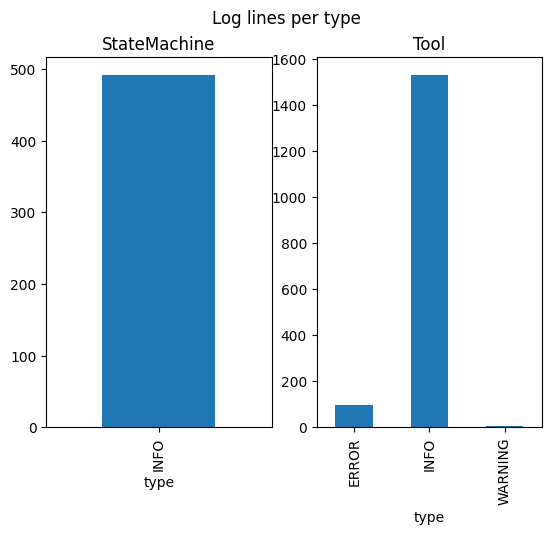

In [17]:
# plot the number of log lines per type
fig = plt.figure()
plt.subplot(1, 2, 1)
log_sm_df.groupby("type").size().plot(kind='bar', title="StateMachine")

plt.subplot(1, 2, 2)
log_tool_df.groupby("type").size().plot(kind='bar', title="Tool")
# sup title
plt.suptitle("Log lines per type")
plt.show()


In [18]:

def plot_timeline(df, column_label, raw_label=None):
    fig, ax = plt.subplots(figsize=(15, 4), constrained_layout=True)

    for i, (key, grp) in enumerate(df.groupby(["level"])):
        markerline, stemline, baseline = ax.stem(grp["date_time"], grp["level"], linefmt=f"C{i}-", basefmt="k-", label=key)

        plt.setp(markerline, mec="k", mfc="w", zorder=3)
        markerline.set_ydata(np.zeros(len(grp["date_time"])))

        # text
        plt.text(grp["date_time"].iloc[0], grp["level"].iloc[0] + (0.1 * np.sign(grp["level"].iloc[0])), grp[column_label].iloc[0], color=f"C{i}", rotation=0, verticalalignment="center", fontsize=10)

        if raw_label:
            for index, row in grp.iterrows():
                if np.sign(row["level"]) == 1:
                    alignement = "bottom"
                    y = 0.1 + row["level"]
                else:
                    alignement = "top"
                    y = -0.1 + row["level"]
                plt.text(row["date_time"], y, row[raw_label], color=f"C{i}", rotation=90, verticalalignment=alignement, horizontalalignment="left", fontsize=6)

    # second offset = 1/20 of the range
    sec_offset = (df["date_time"].max() - df["date_time"].min()).total_seconds() / 20
    init_date = df["date_time"].min()
    # substraction of sec_offset seconds
    init_date = init_date - pd.Timedelta(seconds=sec_offset)
    plt.text(init_date, -0.6, "StateMachine", color="black", rotation=0, verticalalignment="center")
    plt.text(init_date, 0.6, "Tool", color="black", rotation=0, verticalalignment="center")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.margins(y=0.1)

    plt.show()


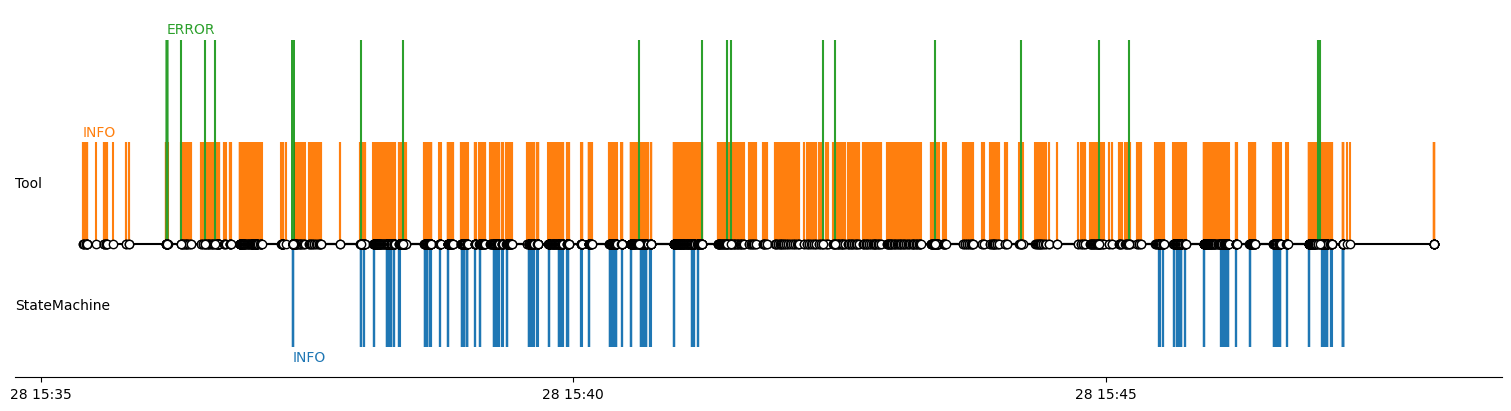

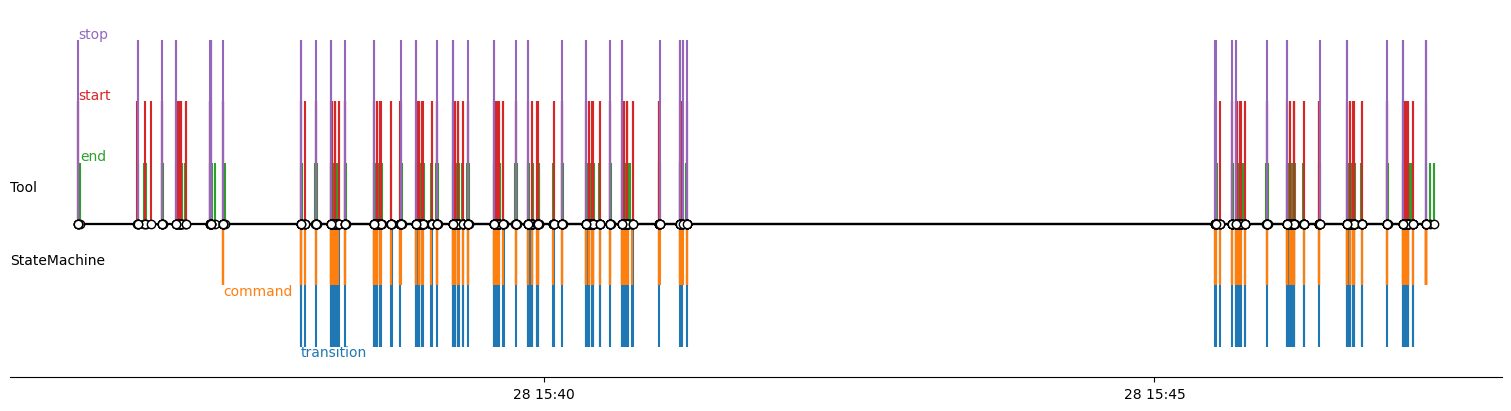

In [19]:
plot_timeline(log_combined, "type")
plot_timeline(log_only_detailed, "detail")

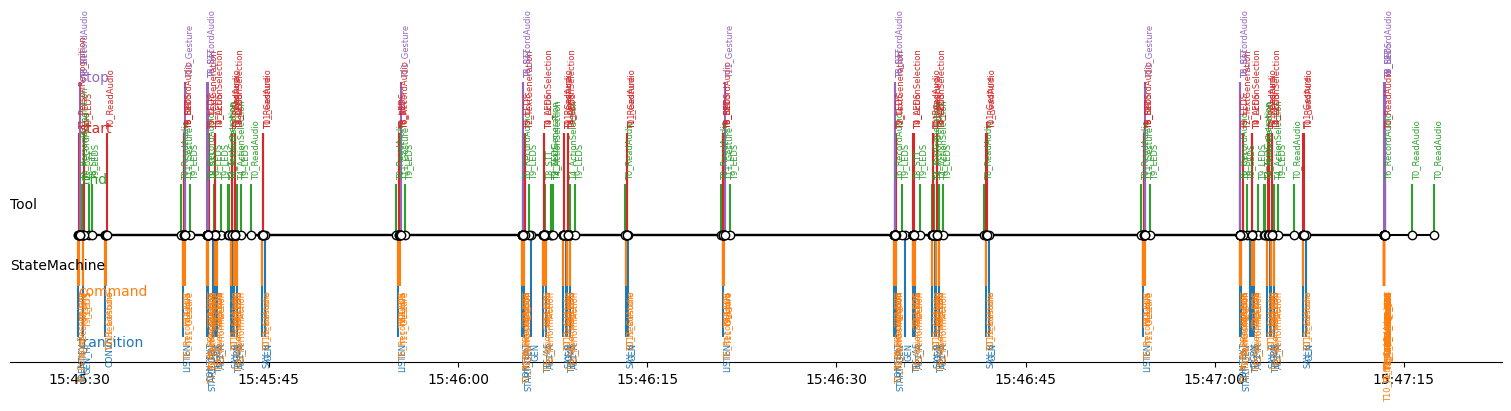

In [20]:
log_zoomed_only_detailed = log_only_detailed[(log_only_detailed["date_time"] > datetime(2024, 5, 28, 15, 45, 0, 0)) & (log_only_detailed["date_time"] < datetime(2024, 5, 28, 15, 48, 0, 0))]
if log_zoomed_only_detailed.empty:
    print("No data in the zoomed area")
else:
    plot_timeline(log_zoomed_only_detailed, "detail", "detail_msg")